# import libraries

In [1]:
import os

In [2]:
import cv2

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
import dask

In [7]:
def show_image(file_path):
    img = cv2.imread(file_path)
    plt.figure(figsize=(40,25))
    plt.imshow(img)
    plt.show()

# Train Image

In [8]:
!ls

test-improved.ipynb  test-original.ipynb


In [9]:
INPUT_DIR = "../Document_Dataset/inputs"

In [10]:
input_image_list = os.listdir(INPUT_DIR)

##### Input suggested in Email

In [11]:
os.path.join(INPUT_DIR, input_image_list[2])

'../Document_Dataset/inputs/document-000-100647.out.000.png'

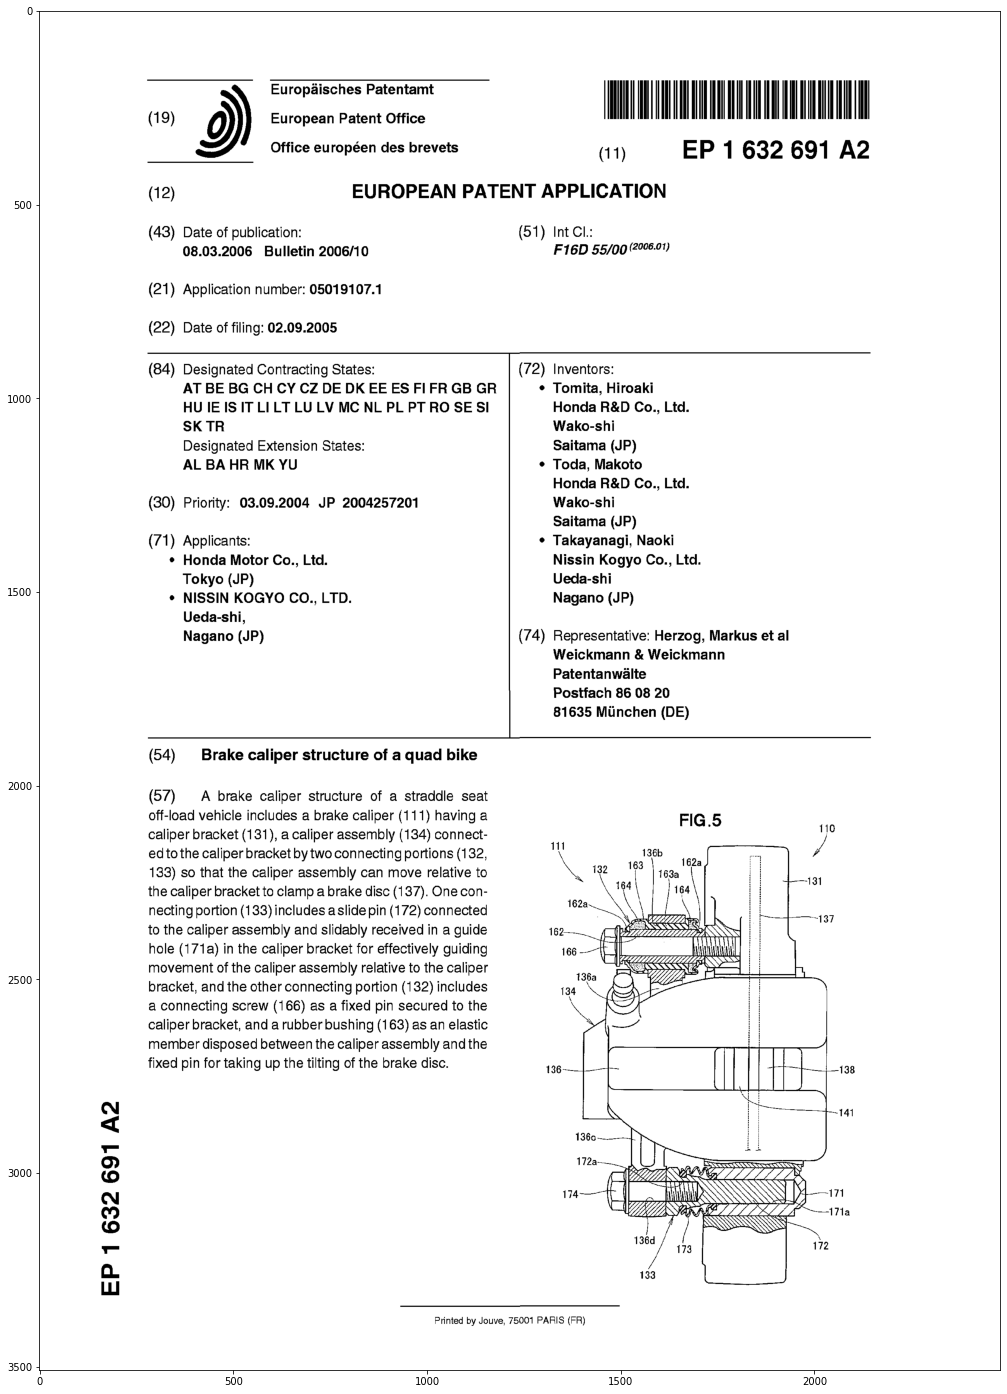

In [12]:
show_image(os.path.join(INPUT_DIR, input_image_list[2]))

In [13]:
test_image_path = os.path.join(INPUT_DIR, input_image_list[2])

In [15]:
@dask.delayed
def segment_image(image_path):
    
    image_array = cv2.imread(image_path)
    image_array = cv2.resize(image_array, (2048, 2048))
    gray_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    _,threshold = cv2.threshold(gray_image,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # assign a rectangle kernel size
    kernel = np.ones((5,5), 'uint8')
    margin_img = cv2.dilate(threshold,kernel,iterations=4)
    
    (contours, _) = cv2.findContours(margin_img.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    image_segment = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        ROI = image_array[y:y+h, x:x+w]
        image_segment.append(cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY))
    
    return image_segment

# Templates

In [16]:
TEMPLATE_DIR = "../Document_Dataset/templates"

In [17]:
template_image_file = [os.path.join(TEMPLATE_DIR,item) for item in os.listdir(TEMPLATE_DIR)]

In [18]:
@dask.delayed
def match_template(img_segment, template):
    # Apply template matching
    template = cv2.resize(template, (2048, 2048))
    res = cv2.matchTemplate(img_segment, template, cv2.TM_CCOEFF_NORMED) 
    x,y = np.where(res >= 0.75)
    if len(x)> 0 and len(y)>0:
        return 1
    else:
        return 0

In [19]:
image_segment = segment_image(test_image_path).compute()

In [20]:
type(image_segment)

list

In [21]:
%%time
image_segment = segment_image(test_image_path).compute()
template_score = []
template_name = []
for template_image in template_image_file:
    template = cv2.imread(template_image)
    gray_image = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    cumul_point = 0
    break
    for segment in image_segment:
        cumul_point= cumul_point+match_template(segment, gray_image).compute()
    template_score.append(cumul_point)
    template_name.append(template_image)

CPU times: user 455 ms, sys: 69.9 ms, total: 525 ms
Wall time: 632 ms


In [23]:
type(gray_image)

numpy.ndarray

#### ouput suggested

In [19]:
template_name[np.argmax(template_score)]

'../Document_Dataset/templates/document-006-101162.in.000.png'

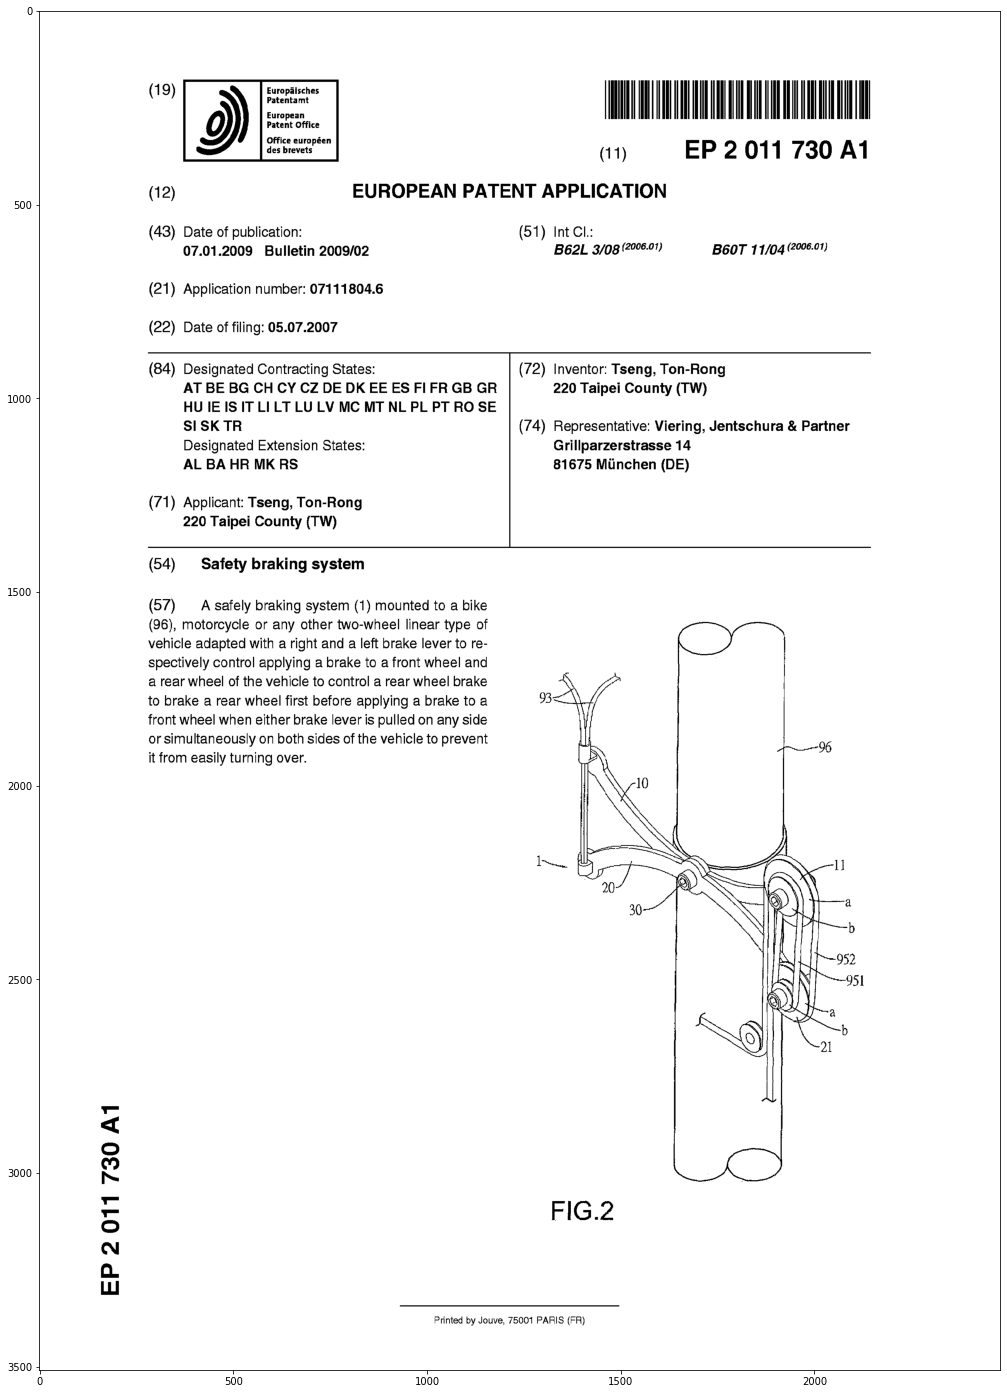

In [20]:
show_image(template_name[np.argmax(template_score)])